In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My \Drive/Sem \8 \files/
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Sem 8 files
 data  'Fri Feb 14 09_06_16 2020.json'


In [2]:
!apt-get install -y libspatialindex-c4v5
!pip3.6 install osmnx

import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import math

from shapely.geometry import box
from heapq import heappush, heappop
from itertools import count
from rtree import index

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-c4v5 is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [0]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes.pkl')

In [0]:
def process_speed_band(df):
    
    # Define Locations
    def truncate(number, digits) -> float:
        stepper = 10.0 ** digits
        return math.trunc(stepper * number) / stepper
    
    location = df['Location'].values
    i = 0
    
    for loc in location:
        x1, y1, x2, y2 = [float(n) for n in loc.split(' ')]
        
        x1 = truncate(x1, 7)
        y1 = truncate(y1, 7)
        x2 = truncate(x2, 7)
        y2 = truncate(y2, 7)
        
        if y1 < y2:
            bottom = y1
            top = y2
        else:
            bottom = y2
            top = y1
            
        if x1 < x2:
            left = x1
            right = x2
        else:
            left = x2
            right = x1
        
        df['Location'].values[i] = (left, bottom, right, top)
        i += 1 
    
    # Process maximum speeds
    i = 0
    for x in df['SpeedBand']:
        if x == 0:
            df['MaximumSpeed'][i] = '50'
        i += 1 

In [6]:
f = open("Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)
# speed_bands.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
def calculate_congestion(G, edges, speed_bands):
    # Define Location    
    location = edges['geometry'].values
    i = 0
    Location = []
    
    for loc in location:        
        x1 = loc.xy[1][-1]
        y1 = loc.xy[0][-1]
        x2 = loc.xy[1][0]
        y2 = loc.xy[0][0]
        
        if y1 < y2:
            bottom = y1
            top = y2
        else:
            bottom = y2
            top = y1
            
        if x1 < x2:
            left = x1
            right = x2
        else:
            left = x2
            right = x1
        
        Location.append((left, bottom, right, top))
        i += 1 
        
    edges['Location'] = Location
    
    
    # Define observed_speed using speedband dataset 
    
    # key: maximum speed ,value: location
    idx = index.Index()
    Location = speed_bands['Location']
    Speed = speed_bands['MaximumSpeed'].astype(float)

    for speed, loc in zip(Speed, Location):
        idx.insert(int(speed), loc)
    
    # Find intersections
    observed_speed = []
    Location = edges['Location']

    for loc in Location:
        max_speeds = list(idx.intersection(loc))

        if len(max_speeds) == 0: # edge didn't intersect with any speed band
            observed_speed.append(70)
        else:
            observed_speed.append(sum(max_speeds)/len(max_speeds))  

    edges['observed_speed'] = observed_speed
    
    
    # Define BPR heuristic for each road link
    bpr = dict()
    n = len(edges['u'])

    for i in range (n):
        u = edges['u'][i]
        v = edges['v'][i]
        key = edges['key'][i]
        time = float(edges['travel_time'][i])
        flow = float(edges['observed_speed'][i])
        capacity = float(edges['maxspeed'][i])
        bpr[(u,v,key)] = time * (1 + 0.15*(flow/capacity)**4)
        
    nx.set_edge_attributes(G, bpr, 'BPR')

In [0]:
calculate_congestion(G, edges, speed_bands)
# edges.head()

### Finding shortest route between centroid of map and another point

In [12]:
# Boundary Box of entire area
bbox = box(*edges.unary_union.bounds)
orig_point = bbox.centroid
print(orig_point)

POINT (103.82129505 1.3515309)


In [9]:
target_point = nodes[nodes['osmid'] == 1820000257].geometry.values[0]
print(target_point)

POINT (103.9326163 1.3565805)


In [0]:
orig_xy = (orig_point.y, orig_point.x)
target_xy = (target_point.y, target_point.x)

In [0]:
# key: node label ,value: location
idx = index.Index()
xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_label = nodes['osmid']

for node, x, y in zip(node_label, xx, yy):
    idx.insert(int(node), (x,y,x,y))

In [0]:
def find_nearest_nodes(source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = list(idx.intersection((west, south, east, north)))    
    return candidate_nodes

In [0]:
# Max distance for walking is 700m (10 min * 1.2 m/s)
# Find all nodes within 720 m from candidate sources and candidate destinations
candidate_dest = find_nearest_nodes(target_xy, 700, idx)
candidate_source = find_nearest_nodes(orig_xy, 700, idx)

In [17]:
# Perform SSP for all paths
min_cost = float('inf')
final_dict = dict()

for source in candidate_source:
    G.add_node(source, demand = -1)
    
    for destination in candidate_dest:
        print(source, destination)
        G.add_node(destination, demand = 1)
        flow_cost, flowDict = nx.capacity_scaling(G, weight='BPR')
        #change demand back to 0 so that another destination can be taken as target
        G.add_node(destination, demand = 0)
         
        # Choose one with least travel time
        if flow_cost < min_cost:
            final_dict = flowDict
            min_cost = flow_cost
            start = source
            target = destination
    
    #change demand back to 0 so that another source can be taken as start
    print("hi")
    G.add_node(source, demand = 0)

print(min_cost) #travel time in sec # ~44 min

1318459092 7013732733
1318459092 5175554784
1318459092 5175554795
1318459092 5175554782
1318459092 4574348137
1318459092 5175554790
1318459092 7013732730
1318459092 992571865
1318459092 4663363888
1318459092 5266964778
1318459092 992571805
1318459092 992571815
1318459092 5175554811
1318459092 7011940540
1318459092 5175554838
1318459092 7011940535
1318459092 5266964774
1318459092 5266964781
1318459092 4663372158
1318459092 4663372159
1318459092 4663372160
1318459092 7013732724
1318459092 5175554765
1318459092 7013732721
1318459092 5175554840
1318459092 5175554839
1318459092 5175554810
1318459092 5175554842
1318459092 5175554783
1318459092 4574348136
1318459092 5175554809
1318459092 7013732727
1318459092 4605217482
1318459092 7013732725
1318459092 5175554796
1318459092 5175554803
1318459092 3182619362
1318459092 6281637319
1318459092 4661984546
1318459092 1820026269
1318459092 1820026248
1318459092 6281637317
1318459092 1820026231
1318459092 4660426171
1318459092 6281637324
1318459092 62

In [0]:
def find_route(flow_dict, s ,t):
    route = []
    u = s #current node
    
    while(u != t):  
        flag=0
        for v,x in flow_dict[u].items():
            for k,f in x.items():
                if f > 0:
                    route.append([u,v,k])
                    u = v
                    flag = 1
                    break
            if flag == 1:
                break
    
    return route

In [0]:
edged_route = find_route(final_dict, source, target)

In [0]:
def plot_route(route, G, origin, destination):
    final_route = []
    
    for node in route:
        final_route.append(node[0])        
    final_route.append(route[-1][1])
    
    fig, ax = ox.plot_graph_route(G, final_route, origin_point=origin, destination_point=destination)
    plt.tight_layout()

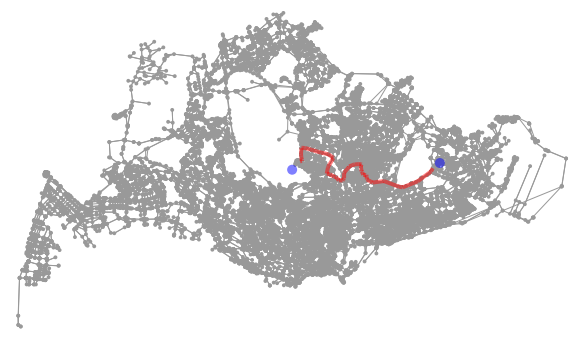

<Figure size 432x288 with 0 Axes>

In [21]:
plot_route(edged_route, G, orig_xy, target_xy)